# Quality Over Year

In this notebook we explore how the average quality of the reviews change during a year for specific samples of beers/breweries. <br>
We want to see if, during particular beer-related events, the quality of the reviews significantly changes.

In particular we want to see the trend of beers made by Munich breweries around the globally renowned Oktoberfest.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

data_path = './../../../data'

In [2]:
def order_months(df):
    month_order = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }

    df['month_order'] = df.index.map(month_order)

    return df.sort_values('month_order').drop(columns='month_order')

def reviews_per_month(df):
    number_of_reviews_month = df.groupby('month').size()
    number_of_reviews_month = number_of_reviews_month.reset_index(name='review_count')

    month_order = [
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ]
    number_of_reviews_month['month'] = pd.Categorical(
        number_of_reviews_month['month'], categories=month_order, ordered=True
    )

    return number_of_reviews_month.sort_values('month')

def review_per_day(df):
    temp = df.groupby('day').size().copy() # necessary?
    return pd.Categorical(temp['day'], ordered=True)

## Oktoberfest

In [28]:
# Find the ids of the breweris of Munich
df_brew = pd.read_csv(os.path.join(data_path, 'RateBeer/breweries_RB_clean.csv'))

In [29]:
df_brew = df_brew[df_brew['location'] == 'Germany']

# List of Oktoberfest breweries
# There are still some breweries that are not in Oktoberfest (e.g. Stuttgarter Hofbräu &#40;Oetker Group&#41;)
# oktoberfest_breweries = [
#     'Augustiner-Bräu', 'Augustiner','Hacker-Pschorr', 'Hofbräu', 'Hofbräu München', 
#     'Löwenbräu', 'Paulaner', 'Spaten'
# ]
oktoberfest_breweries = [
    'Augustiner-Bräu', 'Hacker-Pschorr', 'Hofbräu München', 
    'Löwenbräu Munich', 'Paulaner', 'Spaten'
]


# Check for matches (case-insensitive)
matches = df_brew[
    df_brew['name'].str.contains('|'.join(oktoberfest_breweries), case=False, na=False)
]

ids_okt = matches.id.to_list()

In [30]:
# Find the average score per month
df_score = pd.read_pickle(os.path.join(data_path, 'RateBeer/rev_w_scores.pkl'))

In [31]:
df_score_okt = df_score[df_score['brewery_id'].isin(ids_okt)].copy()

df_score_okt['date'] = pd.to_datetime(df_score_okt['date'])
df_score_okt['year-month'] = df_score_okt['date'].dt.to_period('M')
df_score_okt['month'] = df_score_okt['date'].dt.month_name()
df_score_okt['day'] = df_score_okt['date'].dt.day

exp_month = df_score_okt.groupby('month')['expertness_score'].agg(['mean'])

In [32]:
exp_month = order_months(exp_month)
exp_month.head(12)

,mean
month,
January,8.896332
February,9.103210
March,8.953317
April,9.067435
May,9.192502
June,8.944586
July,9.074038
August,8.904890
September,9.142507


In [33]:
df_score_okt.brewery_name.value_counts()

brewery_name
Paulaner Brauerei &#40;Schörghuber&#41;                 17925
Spaten-Franziskaner-Bräu &#40;InBev&#41;                11666
Augustiner-Bräu                                          3100
Löwenbräu Munich &#40;InBev&#41;                         2687
Paulaner Bräuhaus &#40;Brewpub Munich&#41;                245
Hacker-Pschorr Bavaria Bräu &#40;brewpub Munich&#41;      127
Name: count, dtype: int64

In [34]:
# Let's check if it is statistically significant
number_of_reviews_month = reviews_per_month(df_score_okt)

Text(0.5, 0.98, 'Analysis of reviews of breweries present at Oktoberfest')

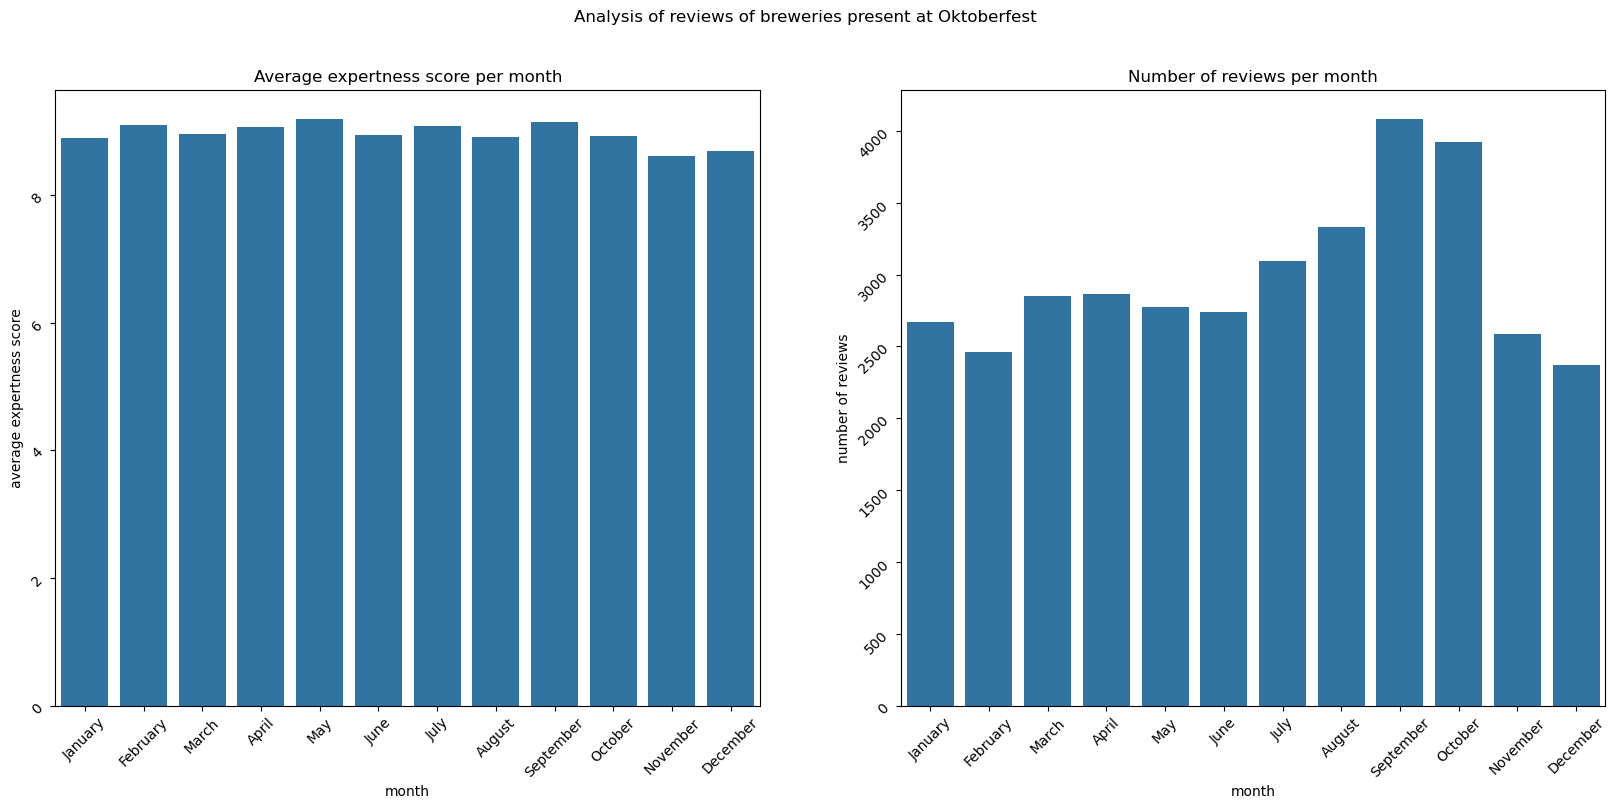

In [35]:
fig, ax = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

sns.barplot(x='month', y='mean', data=exp_month, ax=ax[0])
ax[0].tick_params(rotation=45)
ax[0].set_ylabel('average expertness score')
ax[0].set_title('Average expertness score per month')

sns.barplot(x='month', y='review_count', data=number_of_reviews_month, ax=ax[1])
ax[1].tick_params(rotation=45)
ax[1].set_ylabel('number of reviews')
ax[1].set_title('Number of reviews per month')

fig.suptitle('Analysis of reviews of breweries present at Oktoberfest')

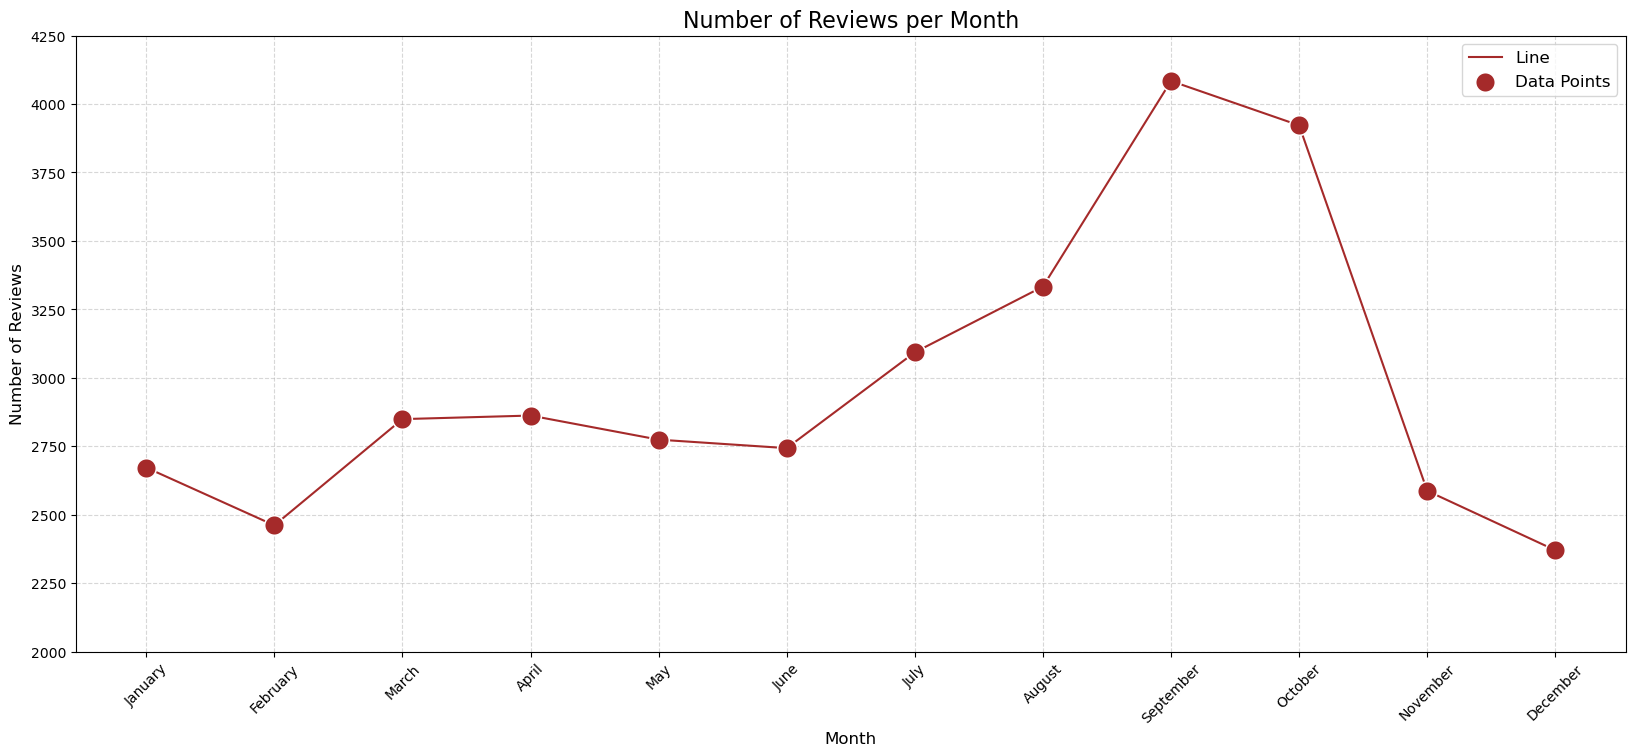

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
color = 'brown'

# Plot the line chart
sns.lineplot(x='month', y='review_count', data=number_of_reviews_month, ax=ax, color=color)

# Add bigger dots on each data point
sns.scatterplot(x='month', y='review_count', data=number_of_reviews_month, ax=ax, 
                color=color, s=200, label='Number of reviews', zorder=10)

# Customize the chart
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylim(2000, 4250)
ax.set_title('Number of Reviews per Month', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

In [33]:
df_score_exact = df_score_okt[
    ((df_score_okt['month'] == 'September') & (df_score_okt['day'] > 15)) |
    ((df_score_okt['month'] == 'October') & (df_score_okt['day'] <= 3))
]

mean_exp_oktoberfest = df_score_exact['expertness_score'].mean()
mean_exp_year = df_score_okt['expertness_score'].mean()
print(mean_exp_oktoberfest)
print(mean_exp_year)

print(f"Increase over the year = {(mean_exp_oktoberfest/mean_exp_year - 1)*100}%")

9.137614678899082
8.96841958041958
Increase over the year = 1.8865653748950217%


In [ ]:
del df_score, df_brew, df_score_exact, df_score_okt

### Only Oktoberfest's beers

Let's only focus on specifically the beers present at Oktoberfest

<p style="color:red; font-size:20px; font-weight:bold;"> I don't believe this is necessary </p>

In [12]:
# df_beer = pd.read_csv(os.path.join(data_path, 'RateBeer/beers_RB_clean.csv'))

In [13]:
# df_beer = df_beer[df_beer['brewery_name'].isin(oktoberfest_breweries)]

# len(df_beer)
# ??? TODO!!!
# Worth it?

In [14]:
# del df_beer

## American beers

I now try to check if American beers have a particular date that, on average, lowers the score of the reviews.

We start analyzing the 4th of July

In [3]:
df_score = pd.read_pickle(os.path.join(data_path, 'BeerAdvocate/rev_w_scores.pkl'))
df_users = pd.read_csv(os.path.join(data_path, 'BeerAdvocate/users_BA_clean.csv'))

In [4]:
df_users = df_users[
    df_users['location'].str.contains('|'.join(['United States']), case=False, na=False)
]

american_users = df_users.user_id.to_list()

In [5]:
# Let's only take in consideration the month of July
df_score_july = df_score.copy()
df_score_july = df_score_july[df_score_july['user_id'].isin(american_users)]
df_score_july['date'] = pd.to_datetime(df_score_july['date'])
df_score_july['month'] = df_score_july['date'].dt.month_name()
df_score_july['day'] = df_score_july['date'].dt.day

df_score_july = df_score_july[df_score_july['month'] == 'July']


exp_july = df_score_july.groupby('day')['expertness_score'].agg(['mean'])
exp_july.head(31)

,mean
day,
1,14.664388
2,14.197883
3,14.379326
4,13.936333
5,14.149630
6,14.516202
7,14.524897
8,14.424606
9,14.507191


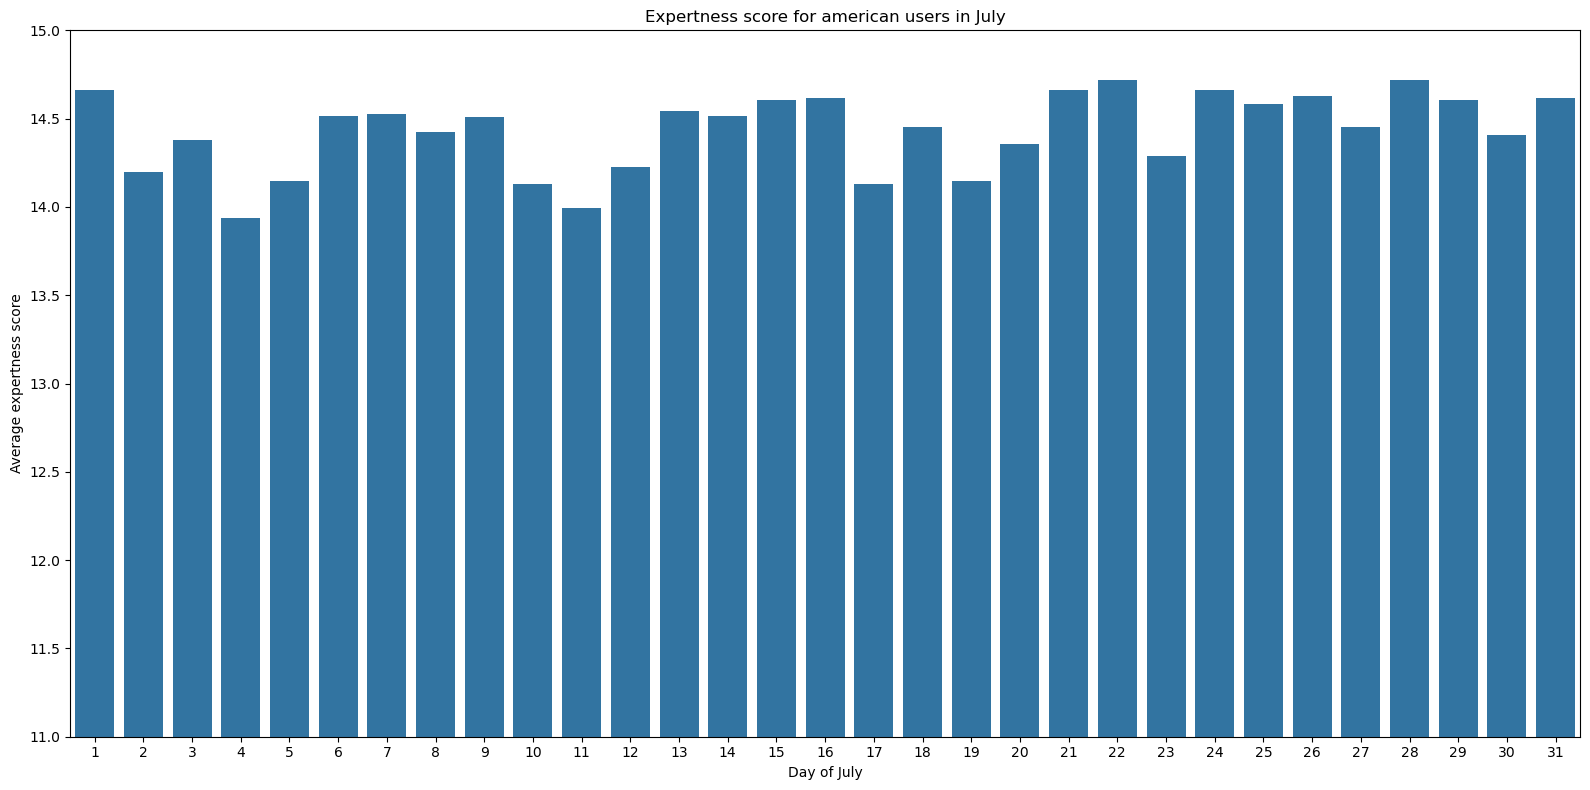

In [6]:
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(x='day', y='mean', data=exp_july, ax=ax)
ax.set_ylabel('Average expertness score')
ax.set_xlabel('Day of July')
ax.set_title('Expertness score for american users in July')
ax.set_ylim(11, 15)

plt.tight_layout()
plt.show() 

In [7]:
# TODO: Check statistical significance with reviews per day!

Indeed, the lowest average experness score is the 4th of July. Is it significant tho?

In [9]:
df_score_year = df_score.copy()
df_score_year = df_score_year[df_score_year['user_id'].isin(american_users)]
df_score_year['date'] = pd.to_datetime(df_score_year['date'])
df_score_year['month'] = df_score_year['date'].dt.month_name()

exp_month = df_score_year.groupby('month')['expertness_score'].agg(['mean'])
exp_month = order_months(exp_month)
exp_month.head(12)

,mean
month,
January,14.460717
February,14.467624
March,14.421249
April,14.381779
May,14.355018
June,14.414182
July,14.427582
August,14.601504
September,14.497624


In [18]:
# rev_july = df_score_year[df_score_year['month'] == 'July'].groupby('day')['expertness_score'].agg(['size'])
rev_july = df_score_july.groupby('day')['expertness_score'].agg(['size'])
rev_july.head(31)

,size
day,
1,5998
2,6236
3,6414
4,7068
5,5948
6,6203
7,6306
8,6161
9,6536


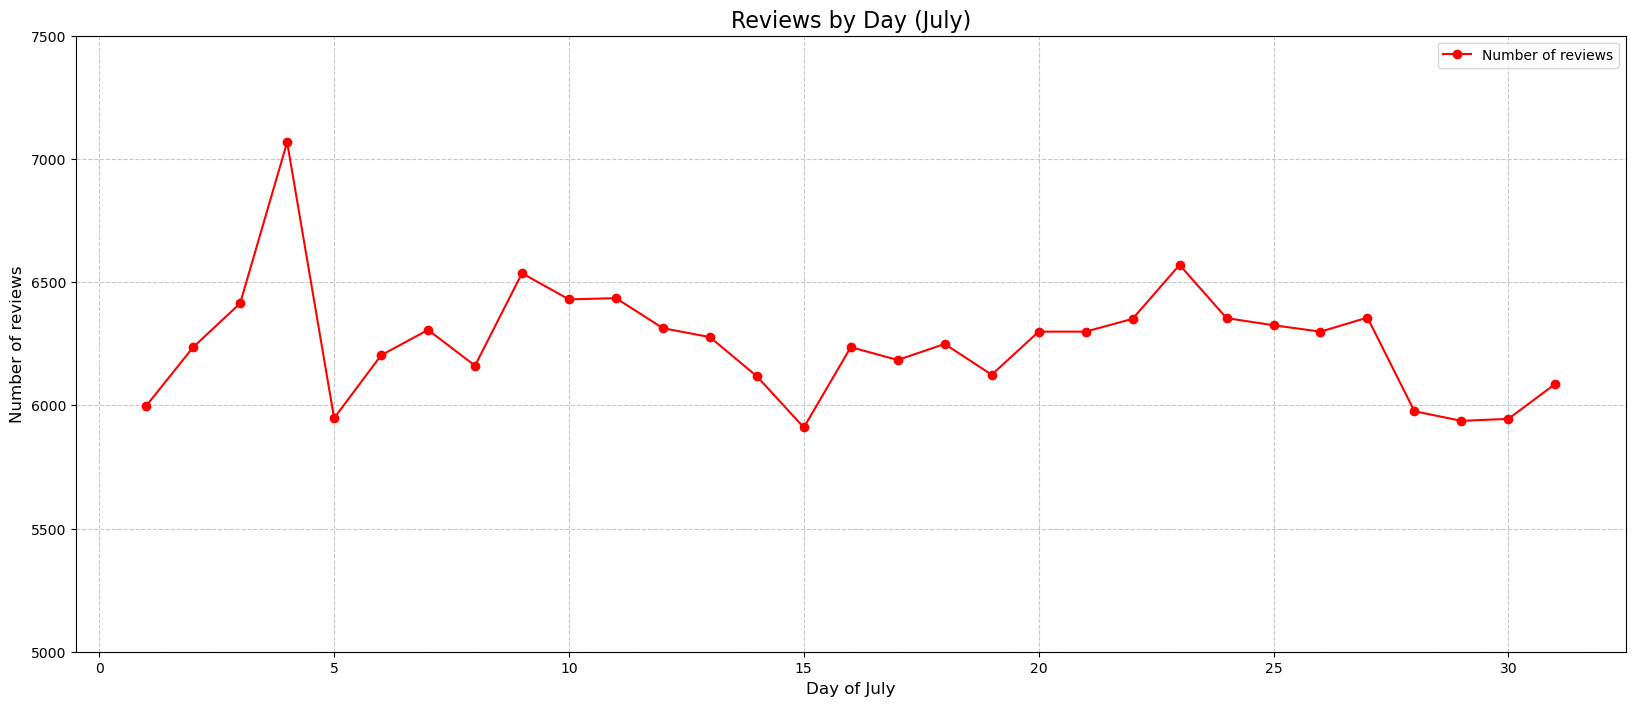

In [62]:
# Plot the line chart
plt.figure(figsize=(20, 8))
plt.plot(rev_july.index, rev_july['size'], marker='o', linestyle='-', color='r', label='Number of reviews')
plt.title('Reviews by Day (July)', fontsize=16)
plt.xlabel('Day of July', fontsize=12)
plt.ylabel('Number of reviews', fontsize=12)
plt.ylim(5000, 7500)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [16]:
rev_per_month = df_score_year.groupby('month')['expertness_score'].agg(['size'])
rev_per_month = order_months(rev_per_month)
rev_per_month.head(12)

,size
month,
January,219002
February,196857
March,209814
April,196200
May,198387
June,193333
July,193944
August,191274
September,176991


No significant lowering of score in July

In [12]:
df_score_july.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,mouthfeel,brewing,technical,appearance,judgment,off_flavors,miscellaneous,expertness_score,month,day
8,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2012-07-14,OtherShoe2,othershoe2.233642,4.0,...,2,2,2,1,0,0,3,17,July,14
17,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2011-07-16,ColSanders123,colsanders123.545441,4.0,...,2,0,1,2,0,1,2,10,July,16
18,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2011-07-15,DerekP,derekp.400402,3.5,...,2,1,0,1,0,1,1,8,July,15
19,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2011-07-11,JayS2629,jays2629.517433,3.0,...,3,2,0,3,0,2,2,20,July,11
20,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2011-07-07,puboflyons,puboflyons.237852,3.5,...,3,2,2,1,0,1,2,14,July,7


In [ ]:
df_americans = df_score[df_score['user_id'].isin(american_users)].copy()
mean_exp_all = df_americans['expertness_score'].mean()
mean_exp_july = df_score_year.loc['July']['mean']
mean_exp_4j = exp_july.loc[4]['mean']

print(f"Mean over the year = {mean_exp_all}\nMean over the month of March = {mean_exp_july}\nmean the day of the event = {mean_exp_4j}")
print(f"\nIncrease over the year = {(mean_exp_4j/mean_exp_all - 1)*100}%\nIncrease over the month = {(mean_exp_4j/mean_exp_july - 1)*100}%")

Mean over the year = 14.484388391005975
Mean over the month of March = 14.42758218867302
mean the day of the event = 13.936332767402376

Increase over the year = -3.7837677974992157%
Increase over the month = -3.404932405488692%


In [21]:
del df_score_year, df_score, df_score_july, df_users

## St. Patrick's Day

Another celebration where a lot of beer is drunk is during St.Patrick's day on the 17th of March.<br>
Interestingly, May has the highest score and hold an important [Craft Beer festival](https://www.theirishplace.com/events/irish-craft-beer-festival/).

Some of the groups of data that we might want to analyze are:
- Brewery: Guinness
- Type of beers: Irish Red Ales
- Users: Irish (altough, many people around the world celebrate it, so we might want to expand)

In [45]:
df_score = pd.read_pickle(os.path.join(data_path, 'RateBeer/rev_w_scores.pkl'))
df_users = pd.read_csv(os.path.join(data_path, 'RateBeer/users_RB_clean.csv'))
df_brew = pd.read_csv(os.path.join(data_path, 'RateBeer/breweries_RB_clean.csv'))

Let's start with Guinness.<br>
'St. James's Gate Brewery' is the name of the official Guinness

In [46]:
# This takes the official Guinness breweries, and other with the name "Guinness"
df_guinness = df_brew[df_brew['name'].str.contains('|'.join(['Guinness', 'St. James']), case=False)].copy()

df_guinness.head(6)

,id,location,name,nbr_beers
246,13088,Cameroon,Guinness Cameroon,2
305,3194,Nigeria,Guinness Nigeria,6
11547,5070,Ghana,Guinness Ghana,6
12773,13,Ireland,St. Jamess Gate (Diageo),64
12810,2097,Ireland,Macardle Moore (Guinness),1
20573,3658,England,McGuinness,4


In [47]:
df_irish = df_brew[df_brew['location'].str.contains('Ireland', case=False)].copy()

irish_brew_ids = df_irish.id.to_list()

In [48]:
df_score_guinness = df_score[df_score['brewery_name'].str.contains('|'.join(['Guinness', 'St. James']), case=False)].copy()
df_score_irish = df_score[df_score['brewery_id'].isin(irish_brew_ids)].copy()

In [49]:
# Some breweries are not included with this method.
print(f"{df_score_irish.brewery_id.nunique()}\n{len(irish_brew_ids)}")

146
156


In [50]:
df_score_guinness['date'] = pd.to_datetime(df_score_guinness['date'])
df_score_guinness['month'] = df_score_guinness['date'].dt.month_name()
df_score_guinness['day'] = df_score_guinness['date'].dt.day


exp_guinness_may = df_score_guinness[df_score_guinness['month'] == 'May'].groupby('day')['expertness_score'].agg(['mean'])
exp_guinness_march = df_score_guinness[df_score_guinness['month'] == 'March'].groupby('day')['expertness_score'].agg(['mean'])
exp_guinness_march.head(31)

,mean
day,
1,8.375000
2,7.272727
3,8.176471
4,5.959184
5,8.623188
6,8.823529
7,6.661538
8,8.448276
9,7.568182


In [51]:
exp_guinness_year = df_score_guinness.groupby('month')['expertness_score'].agg(['mean'])

exp_guinness_year = order_months(exp_guinness_year)
exp_guinness_year.head(12)

,mean
month,
January,8.315403
February,8.338086
March,8.270540
April,8.137954
May,8.943820
June,8.075791
July,8.094906
August,7.824964
September,8.558891


Interestingly, May has the highest average expertness score!

In [52]:
mean_exp_all = df_score_guinness['expertness_score'].mean()
mean_exp_march = exp_guinness_year.loc['March']['mean']
mean_exp_stP = exp_guinness_march.loc[17]['mean']

print(f"Mean over the year = {mean_exp_all}\nMean over the month of March = {mean_exp_march}\nmean the day of the event = {mean_exp_stP}")
print(f"\nIncrease over the year = {(mean_exp_stP/mean_exp_all - 1)*100}%\nIncrease over the month = {(mean_exp_stP/mean_exp_march - 1)*100}%")

Mean over the year = 8.352301439086016
Mean over the month of March = 8.270540172492057
mean the day of the event = 10.481132075471699

Increase over the year = 25.487952654862966%
Increase over the month = 26.728506927904228%


In [53]:
df_score_irish['date'] = pd.to_datetime(df_score_irish['date'])
df_score_irish['month'] = df_score_irish['date'].dt.month_name()
df_score_irish['day'] = df_score_irish['date'].dt.day


exp_irish_march = df_score_irish[df_score_irish['month'] == 'March'].groupby('day')['expertness_score'].agg(['mean'])
exp_irish_may = df_score_irish[df_score_irish['month'] == 'May'].groupby('day')['expertness_score'].agg(['mean'])
exp_irish_july = df_score_irish[df_score_irish['month'] == 'July'].groupby('day')['expertness_score'].agg(['mean']) # It's probably best to check international beers
exp_irish_march.head(31)

,mean
day,
1,10.270677
2,9.142857
3,8.609375
4,8.628571
5,9.100840
6,9.951613
7,8.302158
8,9.650485
9,9.623596


The 17th of March stands out as the day with the highest reviews!

In [54]:
exp_irish_year = df_score_irish.groupby('month')['expertness_score'].agg(['mean'])

exp_irish_year = order_months(exp_irish_year)
exp_irish_year.head(12)

,mean
month,
January,9.401218
February,9.346032
March,9.571514
April,9.749001
May,9.847636
June,9.621367
July,9.532421
August,9.277108
September,9.724660


Again, May is the month with the highest expertness score for irish beers!

In [55]:
reviews_per_month_irish = reviews_per_month(df_score_irish)

Text(0.5, 0.98, 'Analysis of reviews of breweries present at Oktoberfest')

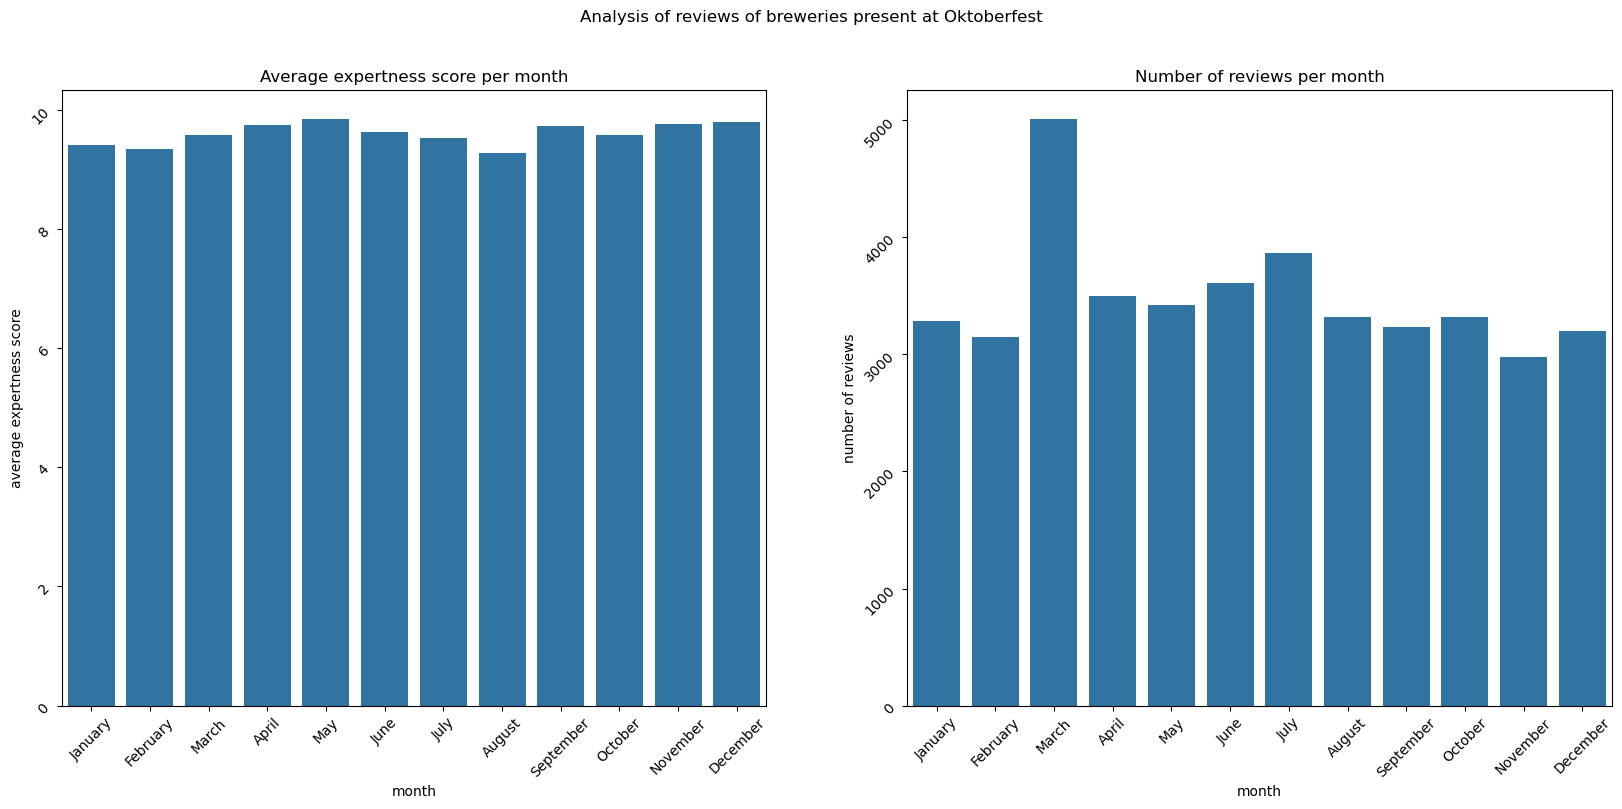

In [56]:
fig, ax = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

sns.barplot(x='month', y='mean', data=exp_irish_year, ax=ax[0])
ax[0].tick_params(rotation=45)
ax[0].set_ylabel('average expertness score')
ax[0].set_title('Average expertness score per month')

sns.barplot(x='month', y='review_count', data=reviews_per_month_irish, ax=ax[1])
ax[1].tick_params(rotation=45)
ax[1].set_ylabel('number of reviews')
ax[1].set_title('Number of reviews per month')

fig.suptitle('Analysis of reviews of breweries present at Oktoberfest')

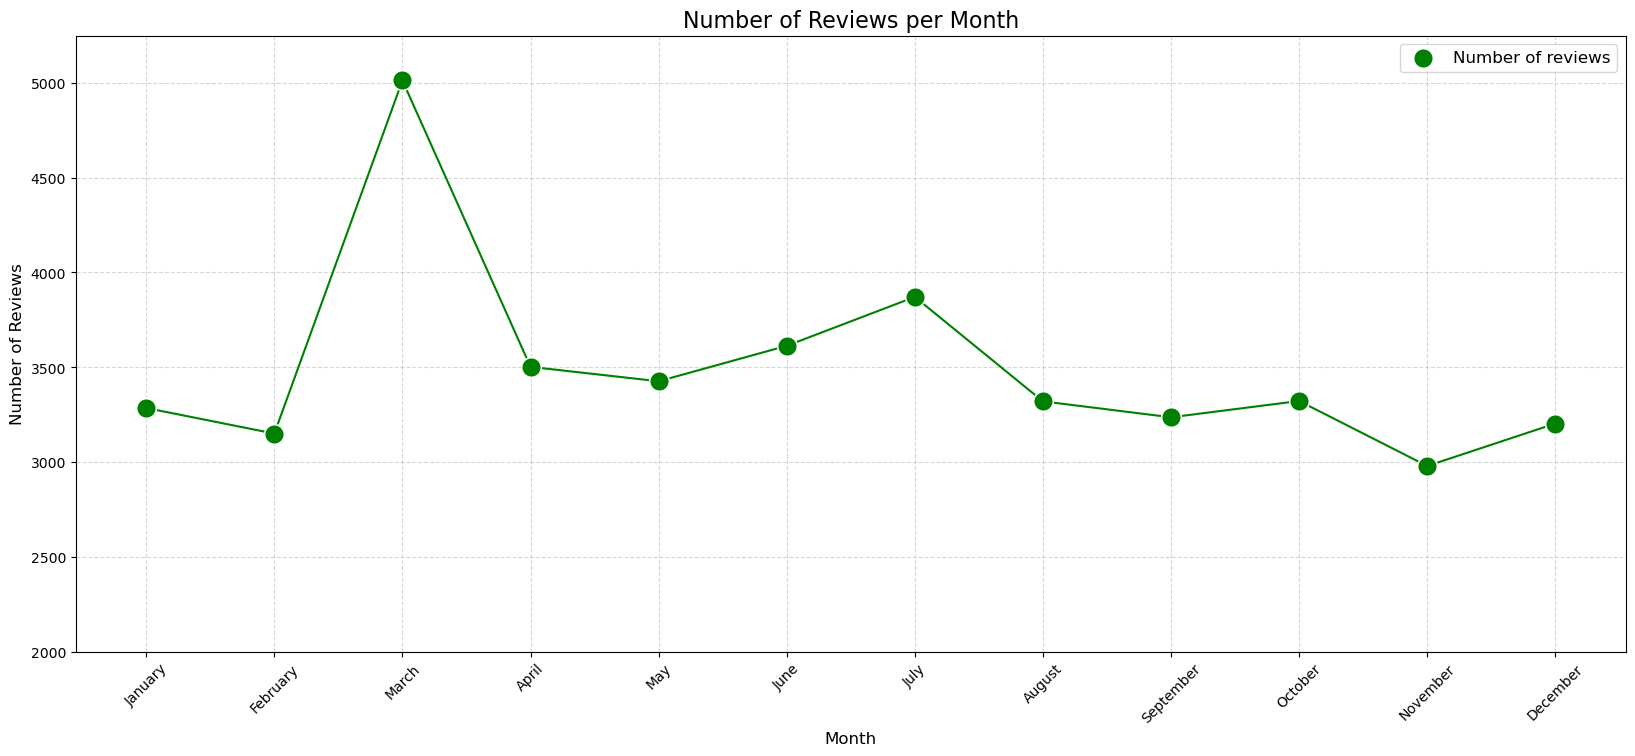

In [61]:
fig, ax = plt.subplots(figsize=(20, 8))
color = 'green'

# Plot the line chart
sns.lineplot(x='month', y='review_count', data=reviews_per_month_irish, ax=ax, color=color)

# Add bigger dots on each data point
sns.scatterplot(x='month', y='review_count', data=reviews_per_month_irish, ax=ax, 
                color=color, s=200, label='Number of reviews', zorder=10)

# Customize the chart
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylim(2000, 5250)
ax.set_title('Number of Reviews per Month', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

### Try with only the official Guinness brewery

In [48]:
df_score_guinness_official = df_score[df_score['brewery_name'].str.contains('|'.join(['St. James']), case=False)].copy()

df_score_guinness_official['date'] = pd.to_datetime(df_score_guinness_official['date'])
df_score_guinness_official['month'] = df_score_guinness_official['date'].dt.month_name()
df_score_guinness_official['day'] = df_score_guinness_official['date'].dt.day


exp_guinness_official_may = df_score_guinness_official[df_score_guinness_official['month'] == 'May'].groupby('day')['expertness_score'].agg(['mean'])
exp_guinness_official_march = df_score_guinness_official[df_score_guinness_official['month'] == 'March'].groupby('day')['expertness_score'].agg(['mean'])
exp_guinness_official_march.head(31)

,mean
day,
1,8.606061
2,7.000000
3,7.960000
4,5.959184
5,8.421053
6,8.840000
7,6.393443
8,8.448276
9,7.738095


This wierd results makes me think that there is not a significant number of reviews to make this study.

In [49]:
exp_guinness_official_year = df_score_guinness_official.groupby('month')['expertness_score'].agg(['mean'])

exp_guinness_official_year = order_months(exp_guinness_official_year)
exp_guinness_official_year.head(12)

,mean
month,
January,8.279563
February,8.278179
March,8.202087
April,8.134871
May,8.886950
June,8.042406
July,8.054014
August,7.739261
September,8.511628


The pattern is the same, but it's not impressive

In [35]:
del df_score, df_users, df_brew, df_guinness, df_irish, df_score_guinness, df_score_irish, df_score_guinness_official, exp_guinness_official_year, exp_guinness_official_may

#### Next steps

Investigate on the worst month for Ireland: **July**<br>
[Hagstravaganza](https://www.thewhitehag.com/hagstravaganza/)